# Purposes of this document

the goal is to actually
examine the relevance of the features with respect to the estimated intentions.

we fit the est. intentions to the features(spike_counts) 
and test the p_values of the reg. coefficients. 

we expect to see:
1. for each row,  it should similar to the encoder C matrix
2. the non-relevant features or non-encoding features would have close to 1 p-values. 

in the end, 
we will demonstrate the mismatch through
1. the rewarded trials and the reward trial rate. 
2. qualitative comparisions of trajectories. 
3. the tuning directions of C. and the tracking performance using correlation coefficients

# ideas

we play with the supervision way



do feature selection in unsupervised way
don't have
little variance features can be dropped. 
this would be particularly int.

why feature selection could be separate? 
for instance,  change in the neuron recording.
thing happen at the background. 
quickly capture that. 

finish the simulations
1. firing rates
2. the convergence is a function of SNR, might be interesing, in the context of feature selection. 

make a  simulation
1. some neurons high SNR, and some neuron low
2. the high SNR might be learnt faster. 
3. train on more higher SNR 
3. gradually add in features. 
4. a nice demo of feature selection of sequentially. 
5. would a scheme that does that be performance beneficial
6. the low SNRS are useful but can be added later. 

connected neural networks.
1. big obvious features that explain well. 
2. some really nice features. \
3. cats and dogs. learn the brightness instead of the animals. 
4. similar things, we have a distribution 

# Experimental setup related to the questions

this part should be configured to directly test the hypothesis put forward in the previous section


In [2]:
import numpy as np

MEAN_FIRING_RATE_START_IN_BASE_2 = 0
MEAN_FIRING_RATE_STOP_IN_BASE_2 = 10

neuron_firing_rates = np.logspace(MEAN_FIRING_RATE_START_IN_BASE_2, 
                                  MEAN_FIRING_RATE_STOP_IN_BASE_2, 
                                  MEAN_FIRING_RATE_STOP_IN_BASE_2  + 1, 
                                 base = 2)

#for comparision
exp_conds = [f'enc. mean fr {str(s)}' for s in neuron_firing_rates]
print(f'we have experimental conditions {exp_conds}')

#setting clda parameters 
##learner: collects paird data at batch_sizes
RHO = 0.5
batch_size = 50


#assistor set up assist level
assist_level = (0.05, 0.0)

#learner and updater: actualy set up rho
UPDATER_BATCH_TIME = 1
UPDATER_HALF_LIFE = np.log(RHO)  * UPDATER_BATCH_TIME / np.log(0.5)


we have experimental conditions ['enc. mean fr 1.0', 'enc. mean fr 2.0', 'enc. mean fr 4.0', 'enc. mean fr 8.0', 'enc. mean fr 16.0', 'enc. mean fr 32.0', 'enc. mean fr 64.0', 'enc. mean fr 128.0', 'enc. mean fr 256.0', 'enc. mean fr 512.0', 'enc. mean fr 1024.0']


In [3]:
# CHANGE: game mechanics: generate task params
N_TARGETS = 8
N_TRIALS = 80

NUM_EXP = len(exp_conds) # how many experiments we are running. 

# Config the experiments

this section largely copyied and pasted from   
bmi3d-sijia(branch)-bulti_in_experiemnts
https://github.com/sijia66/brain-python-interface/blob/master/built_in_tasks/sim_task_KF.py

## load dependant libraries

In [4]:
# import libraries
# make sure these directories are in the python path., 
from bmimultitasks import SimBMIControlMulti, SimBMICosEncKFDec, BMIControlMultiNoWindow
from features import SaveHDF
from features.simulation_features import get_enc_setup, SimKFDecoderRandom, SimCosineTunedEnc,SimIntentionLQRController, SimClockTick
from features.simulation_features import SimHDF, SimTime

from riglib import experiment

from riglib.stereo_opengl.window import FakeWindow
from riglib.bmi import train


from behaviour_metrics import calc_inter_wait_times, filter_state, sort_trials

from weights import calc_p_values_for_spike_batches_use_intended_kin
from weights import calc_single_batch_p_values_by_fitting_kinematics_to_spike_counts
import weights

import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import itertools #for identical sequences

np.set_printoptions(precision=2, suppress=True)


/home/sijia-aw/BMi3D_my/lab_bmi3d/riglib/blackrock/cerelink.py:13: UserWarning: Unable to import cerebus library. Check if is installed if using the Blackrock NeuroPort system
  warnings.warn("Unable to import cerebus library. Check if is installed if using the Blackrock NeuroPort system")


##  behaviour and task setup

In [5]:
seq = SimBMIControlMulti.sim_target_seq_generator_multi(
N_TARGETS, N_TRIALS)

#create a second version of the tasks
seqs = itertools.tee(seq, NUM_EXP + 1)
target_seq = list(seqs[NUM_EXP])

seqs = seqs[:NUM_EXP]


SAVE_HDF = False
SAVE_SIM_HDF = True #this makes the task data available as exp.task_data_hist
DEBUG_FEATURE = False


#base_class = SimBMIControlMulti
base_class = BMIControlMultiNoWindow

#for adding experimental features such as encoder, decoder
feats = []

## encoder

the cosine tuned encoder uses a poisson process, right
https://en.wikipedia.org/wiki/Poisson_distribution
so if the lambda is 1, then it's very likely 

In [6]:
ENCODER_TYPE = 'cosine_tuned_encoder'

#neuron set up : 'std (20 neurons)' or 'toy (4 neurons)' 
N_NEURONS, N_STATES, sim_C = get_enc_setup(sim_mode = 'toy')


#actually multiply out the firing rates. 
sim_C_all = [sim_C * nfr for nfr in neuron_firing_rates]


#set up intention feedbackcontroller
#this ideally set before the encoder
feats.append(SimIntentionLQRController)

#set up the encoder
if ENCODER_TYPE == 'cosine_tuned_encoder' :
    feats.append(SimCosineTunedEnc)
    print(f'{__name__}: selected SimCosineTunedEnc\n')

features.simulation_features: get_enc_setup has a tuning_level of 1 

__main__: selected SimCosineTunedEnc



## decoder setup

In [7]:
#clda on random 
DECODER_MODE = 'random' # random 

   #take care the decoder setup
if DECODER_MODE == 'random':
    feats.append(SimKFDecoderRandom)
    print(f'{__name__}: set base class ')
    print(f'{__name__}: selected SimKFDecoderRandom \n')
else: #defaul to a cosEnc and a pre-traind KF DEC
    from features.simulation_features import SimKFDecoderSup
    feats.append(SimKFDecoderSup)
    print(f'{__name__}: set decoder to SimKFDecoderSup\n')

__main__: set base class 
__main__: selected SimKFDecoderRandom 



##  clda: learner and updater

In [8]:


LEARNER_TYPE = 'feedback' # to dumb or not dumb it is a question 'feedback'
UPDATER_TYPE = 'smooth_batch' #none or "smooth_batch"


#you know what? 
#learner only collects firing rates labeled with estimated estimates
#we would also need to use the labeled data
#now, we can set up a dumb/or not-dumb learner
if LEARNER_TYPE == 'feedback':
    from features.simulation_features import SimFeedbackLearner
    feats.append(SimFeedbackLearner)
else:
    from features.simulation_features import SimDumbLearner
    feats.append(SimDumbLearner)

#to update the decoder.
if UPDATER_TYPE == 'smooth_batch':
    from features.simulation_features import SimSmoothBatch
    feats.append(SimSmoothBatch)
else: #defaut to none 
    print(f'{__name__}: need to specify an updater')
    



## assistor setup

## (Check) config the experiment

In [9]:
if DEBUG_FEATURE: 
    from features.simulation_features import DebugFeature
    feats.append(DebugFeature)
    
if SAVE_HDF: feats.append(SaveHDF)
if SAVE_SIM_HDF: feats.append(SimHDF)
    
    
#pass the real time limit on clock
feats.append(SimClockTick)
feats.append(SimTime)


kwargs_exps = list()

for i in range(NUM_EXP):
    d = dict()
    
    d['assist_level'] = assist_level
    d['sim_C'] = sim_C_all[i]
    d['batch_size'] = batch_size
    
    d['batch_time'] = UPDATER_BATCH_TIME
    d['half_life'] = UPDATER_HALF_LIFE
    
    kwargs_exps.append(d)


kwargs_exps

[{'assist_level': (0.05, 0.0),
  'sim_C': array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.],
         [ 0.,  0.,  0., -1.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  1.,  0.],
         [ 0.,  0.,  0.,  0.,  0., -1.,  0.]]),
  'batch_size': 50,
  'batch_time': 1,
  'half_life': 1.0},
 {'assist_level': (0.05, 0.0),
  'sim_C': array([[ 0.,  0.,  0.,  2.,  0.,  0.,  0.],
         [ 0.,  0.,  0., -2.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  2.,  0.],
         [ 0.,  0.,  0.,  0.,  0., -2.,  0.]]),
  'batch_size': 50,
  'batch_time': 1,
  'half_life': 1.0},
 {'assist_level': (0.05, 0.0),
  'sim_C': array([[ 0.,  0.,  0.,  4.,  0.,  0.,  0.],
         [ 0.,  0.,  0., -4.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  4.,  0.],
         [ 0.,  0.,  0.,  0.,  0., -4.,  0.]]),
  'batch_size': 50,
  'batch_time': 1,
  'half_life': 1.0},
 {'assist_level': (0.05, 0.0),
  'sim_C': array([[ 0.,  0.,  0.,  8.,  0.,  0.,  0.],
         [ 0.,  0.,  0., -8.,  0.,  0.,  0.],
         [

## make and initalize experiment instances

In [10]:
#seed the experiment
np.random.seed(0)

#spawn the task
Exp = experiment.make(base_class, feats=feats)

exps = list()#create a list of experiment

for i,s in enumerate(seqs):
    e = Exp(s, **kwargs_exps[i])
    exps.append(e)

#run the ini
for e in exps: e.init()

metaclass constructor
(<class 'features.simulation_features.SimIntentionLQRController'>, <class 'features.simulation_features.SimCosineTunedEnc'>, <class 'features.simulation_features.SimKFDecoderRandom'>, <class 'features.simulation_features.SimFeedbackLearner'>, <class 'features.simulation_features.SimSmoothBatch'>, <class 'features.simulation_features.SimHDF'>, <class 'features.simulation_features.SimClockTick'>, <class 'features.simulation_features.SimTime'>, <class 'bmimultitasks.BMIControlMultiNoWindow'>)
[<class 'features.simulation_features.SimIntentionLQRController'>, <class 'features.simulation_features.SimCosineTunedEnc'>, <class 'features.simulation_features.SimKFDecoderRandom'>, <class 'features.simulation_features.SimFeedbackLearner'>, <class 'features.simulation_features.SimSmoothBatch'>, <class 'features.simulation_features.SimHDF'>, <class 'features.simulation_features.SimClockTick'>, <class 'features.simulation_features.SimTime'>]

features.simulation_features.SimInte

# Pre-experiment check: check the Kalman filter before training

we replace the encoder using the weights
assume, they are all randomly initialized get the first decoder
get a handle to the first decoder
we check the new decoder C matrix:


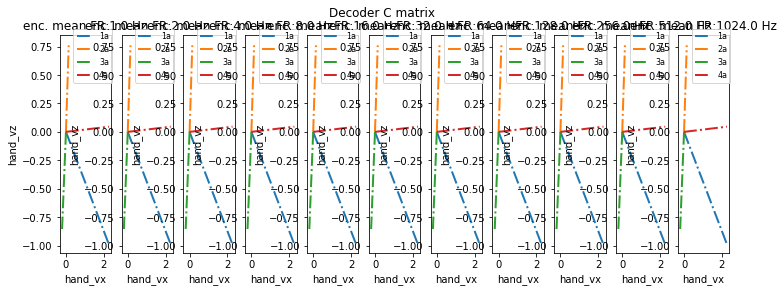

In [11]:
print('we replace the encoder using the weights')
print('assume, they are all randomly initialized get the first decoder')
print('get a handle to the first decoder')
first_decoder = exps[0].decoder
target_C = first_decoder.filt.C
    
#replace the decoder
for i,e in enumerate(exps):
    weights.change_target_kalman_filter_with_a_C_mat(e.decoder.filt, target_C, debug=False)
    
print('we check the new decoder C matrix:')

decoder_c_figure, axs = plt.subplots(nrows=1, 
                               ncols=NUM_EXP, figsize = [12,4])
decoder_c_figure.suptitle('Decoder C matrix ')

for i,e in enumerate(exps):
    e.decoder.plot_C(ax = axs[i])
    axs[i].set_title(exp_conds[i])

# Experiment run: assemble into a complete loop

##  define the function

In [12]:
#make this into a loop

def run_exp_loop(exp,  **kwargs):
        # riglib.experiment: line 597 - 601
    #exp.next_trial = next(exp.gen)
    # -+exp._parse_next_trial()np.arraynp.array


    # we need to set the initial state
    # per fsm.run:  line 138


    # Initialize the FSM before the loop
    exp.set_state(exp.state)
    
    finished_trials = exp.calc_state_occurrences('wait')
    print(f'finished: {finished_trials}')


    while exp.state is not None:

        # exp.fsm_tick()

        ### Execute commands#####
        exp.exec_state_specific_actions(exp.state)

        ###run the bmi loop #####
        # _cycle

        # bmi feature extraction, eh
        #riglib.bmi: 1202
        feature_data = exp.get_features()

        # Determine the target_state and save to file
        current_assist_level = exp.get_current_assist_level()
        target_state = exp.get_target_BMI_state(exp.decoder.states)

        # Determine the assistive control inputs to the Decoder
        #update assistive control level
        exp.update_level()
        if np.any(current_assist_level) > 0:
            current_state = exp.get_current_state()

            if target_state.shape[1] > 1:
                assist_kwargs = exp.assister(current_state, 
                                             target_state[:,0].reshape(-1,1), 
                                             current_assist_level, mode= exp.state)
            else:
                assist_kwargs = exp.assister(current_state, 
                                              target_state, 
                                              current_assist_level, 
                                              mode= exp.state)

            kwargs.update(assist_kwargs)
            
        

        # decode the new features
        # riglib.bmi.bmiloop: line 1245
        neural_features = feature_data[exp.extractor.feature_type]

        # call decoder.
        #tmp = exp.call_decoder(neural_features, target_state, **kwargs)
        neural_obs = neural_features
        learn_flag = exp.learn_flag
        task_state = exp.state

        n_units, n_obs = neural_obs.shape
        # If the target is specified as a 1D position, tile to match
        # the number of dimensions as the neural features
        if np.ndim(target_state) == 1 or (target_state.shape[1] == 1 and n_obs > 1):
            target_state = np.tile(target_state, [1, n_obs])

        decoded_states = np.zeros([exp.bmi_system.decoder.n_states, n_obs])
        update_flag = False

        for k in range(n_obs):
            neural_obs_k = neural_obs[:, k].reshape(-1, 1)
            target_state_k = target_state[:, k]

            # NOTE: the conditional below is *only* for compatibility with older Carmena
            # lab data collected using a different MATLAB-based system. In all python cases,
            # the task_state should never contain NaN values.
            if np.any(np.isnan(target_state_k)):
                task_state = 'no_target'

            #################################
            # Decode the current observation
            #################################
            decodable_obs, decode = exp.bmi_system.feature_accumulator(
                neural_obs_k)
            if decode:  # if a new decodable observation is available from the feature accumulator
                prev_state = exp.bmi_system.decoder.get_state()

                exp.bmi_system.decoder(decodable_obs, **kwargs)
                # Determine whether the current state or previous state should be given to the learner
                if exp.bmi_system.learner.input_state_index == 0:
                    learner_state = exp.bmi_system.decoder.get_state()
                elif exp.bmi_system.learner.input_state_index == -1:
                    learner_state = prev_state
                else:
                    print(("Not implemented yet: %d" %
                           exp.bmi_system.learner.input_state_index))
                    learner_state = prev_state

                if learn_flag:
                    exp.bmi_system.learner(decodable_obs.copy(), learner_state, target_state_k, exp.bmi_system.decoder.get_state(
                    ), task_state, state_order=exp.bmi_system.decoder.ssm.state_order)

            decoded_states[:, k] = exp.bmi_system.decoder.get_state()

            ############################
            # Update decoder parameters
            ############################
            if exp.bmi_system.learner.is_ready():
                batch_data = exp.bmi_system.learner.get_batch()
                batch_data['decoder'] = exp.bmi_system.decoder
                kwargs.update(batch_data)
                exp.bmi_system.updater(**kwargs)
                exp.bmi_system.learner.disable()

            new_params = None  # by default, no new parameters are available
            if exp.bmi_system.has_updater:
                new_params = copy.deepcopy(exp.bmi_system.updater.get_result())

            # Update the decoder if new parameters are available
            if not (new_params is None):
                exp.bmi_system.decoder.update_params(
                    new_params, **exp.bmi_system.updater.update_kwargs)
                new_params['intended_kin'] = batch_data['intended_kin']
                new_params['spike_counts_batch'] = batch_data['spike_counts']

                exp.bmi_system.learner.enable()
                update_flag = True

                # Save new parameters to parameter history
                exp.bmi_system.param_hist.append(new_params)



        # saved as task data
        # return decoded_states, update_flag
        tmp = decoded_states
        exp.task_data['internal_decoder_state'] = tmp

        # reset the plant position
        # @riglib.bmi.BMILoop.move_plant  line:1254
        exp.plant.drive(exp.decoder)

        # check state transitions and run the FSM.
        current_state = exp.state

        # iterate over the possible events which could move the task out of the current state
        for event in exp.status[current_state]:
            # if the event has occurred
            if exp.test_state_transition_event(event):
                # execute commands to end the current state
                exp.end_state(current_state)

                # trigger the transition for the event
                exp.trigger_event(event)

                # stop searching for transition events (transition events must be
                # mutually exclusive for this FSM to function properly)
                break

        # sort out the loop params.
        # inc cycle count
        exp.cycle_count += 1

        # save target data as was done in manualControlTasks._cycle
        exp.task_data['target'] = exp.target_location.copy()
        exp.task_data['target_index'] = exp.target_index

        #done in bmi:_cycle after move_plant
        exp.task_data['loop_time'] = exp.iter_time()


        #fb_controller data
        exp.task_data['target_state'] = target_state

        #encoder data
        #input to this is actually extractor
        exp.task_data['ctrl_input'] = np.reshape(exp.extractor.sim_ctrl, (1,-1))

        #actually output
        exp.task_data['spike_counts'] = feature_data['spike_counts']


        #save the decoder_state
        #from BMILoop.move_plant
        exp.task_data['decoder_state'] = exp.decoder.get_state(shape=(-1,1))
        
        #save bmi_data
        exp.task_data['update_bmi'] = update_flag


        # as well as plant data.
        plant_data = exp.plant.get_data_to_save()
        for key in plant_data:
            exp.task_data[key] = plant_data[key]

        # clda data handled in the above call.

        # save to the list hisory of data.
        exp.task_data_hist.append(exp.task_data.copy())
        
        #print out the trial update whenever wait count changes, alright. 
        if finished_trials != exp.calc_state_occurrences('wait'):
            finished_trials = exp.calc_state_occurrences('wait')
            print(f'finished trials :{finished_trials} with a current assist level of {exp.get_current_assist_level()}')


    if exp.verbose:
        print("end of FSM.run, task state is", exp.state)
    
    


## actually running the experiments

In [13]:
for i,e in enumerate(exps):
    run_exp_loop(e, **kwargs_exps[i])
    print(f'Finished running  {exp_conds[i]}')

runseq
finished: 1
assist_level:  0.05


/home/sijia-aw/BMi3D_my/lab_bmi3d/riglib/bmi/kfdecoder.py:372: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  C = np.mat(np.linalg.lstsq(X.T, Y.T)[0].T)


assist_level:  0.045
finished trials :2 with a current assist level of 0.04346666666666667
finished trials :3 with a current assist level of 0.04307222222222223
finished trials :4 with a current assist level of 0.04253055555555556
finished trials :5 with a current assist level of 0.04216666666666667
finished trials :6 with a current assist level of 0.04085833333333334
assist_level:  0.04
finished trials :7 with a current assist level of 0.03914166666666667
finished trials :8 with a current assist level of 0.038615277777777776
finished trials :9 with a current assist level of 0.038205555555555555
finished trials :10 with a current assist level of 0.0376
finished trials :11 with a current assist level of 0.03730833333333333
finished trials :12 with a current assist level of 0.03683055555555556
finished trials :13 with a current assist level of 0.03646666666666667
finished trials :14 with a current assist level of 0.03610694444444445
finished trials :15 with a current assist level of 0.03

finished trials :35 with a current assist level of 0.033481944444444446
finished trials :36 with a current assist level of 0.03319861111111111
finished trials :37 with a current assist level of 0.03283055555555556
finished trials :38 with a current assist level of 0.032556944444444444
finished trials :39 with a current assist level of 0.032273611111111114
finished trials :40 with a current assist level of 0.03207361111111111
finished trials :41 with a current assist level of 0.031705555555555556
finished trials :42 with a current assist level of 0.031181944444444446
finished trials :43 with a current assist level of 0.030747222222222224
finished trials :44 with a current assist level of 0.03044861111111111
finished trials :45 with a current assist level of 0.03014027777777778
finished trials :46 with a current assist level of 0.029856944444444446
finished trials :47 with a current assist level of 0.02951527777777778
finished trials :48 with a current assist level of 0.02913333333333333

finished trials :71 with a current assist level of 0.023756944444444445
finished trials :72 with a current assist level of 0.023447222222222227
finished trials :73 with a current assist level of 0.022738888888888892
finished trials :74 with a current assist level of 0.022405555555555557
finished trials :75 with a current assist level of 0.02206527777777778
finished trials :76 with a current assist level of 0.021655555555555556
finished trials :77 with a current assist level of 0.02138888888888889
finished trials :78 with a current assist level of 0.021163888888888895
finished trials :79 with a current assist level of 0.020872222222222226
finished trials :80 with a current assist level of 0.02053888888888889
finished trials :81 with a current assist level of 0.02031527777777778
end of FSM.run, task state is None
Finished running  enc. mean FR:4.0 Hz
runseq
finished: 1
finished trials :2 with a current assist level of 0.047905555555555555
finished trials :3 with a current assist level of

finished trials :27 with a current assist level of 0.04319166666666667
finished trials :28 with a current assist level of 0.04294722222222223
finished trials :29 with a current assist level of 0.042625
finished trials :30 with a current assist level of 0.0424
finished trials :31 with a current assist level of 0.04216666666666667
finished trials :32 with a current assist level of 0.041947222222222226
finished trials :33 with a current assist level of 0.04170833333333333
finished trials :34 with a current assist level of 0.04148333333333334
finished trials :35 with a current assist level of 0.041225000000000005
finished trials :36 with a current assist level of 0.040933333333333335
finished trials :37 with a current assist level of 0.04054166666666667
finished trials :38 with a current assist level of 0.04033333333333333
finished trials :39 with a current assist level of 0.04008333333333333
finished trials :40 with a current assist level of 0.03984027777777778
finished trials :41 with a 

finished trials :65 with a current assist level of 0.034225000000000005
finished trials :66 with a current assist level of 0.03399722222222222
finished trials :67 with a current assist level of 0.0338
finished trials :68 with a current assist level of 0.03358055555555556
finished trials :69 with a current assist level of 0.033356944444444446
finished trials :70 with a current assist level of 0.033148611111111115
finished trials :71 with a current assist level of 0.03294861111111111
finished trials :72 with a current assist level of 0.032731944444444445
finished trials :73 with a current assist level of 0.03249027777777778
finished trials :74 with a current assist level of 0.032231944444444445
finished trials :75 with a current assist level of 0.03199027777777778
finished trials :76 with a current assist level of 0.031781944444444446
finished trials :77 with a current assist level of 0.03151527777777778
finished trials :78 with a current assist level of 0.0313
finished trials :79 with a

finished trials :22 with a current assist level of 0.04441666666666667
finished trials :23 with a current assist level of 0.04419722222222223
finished trials :24 with a current assist level of 0.04398888888888889
finished trials :25 with a current assist level of 0.043775
finished trials :26 with a current assist level of 0.04357222222222223
finished trials :27 with a current assist level of 0.04335
finished trials :28 with a current assist level of 0.043083333333333335
finished trials :29 with a current assist level of 0.042758333333333336
finished trials :30 with a current assist level of 0.0425
finished trials :31 with a current assist level of 0.04228055555555556
finished trials :32 with a current assist level of 0.042050000000000004
finished trials :33 with a current assist level of 0.041841666666666666
finished trials :34 with a current assist level of 0.041633333333333335
finished trials :35 with a current assist level of 0.0414
finished trials :36 with a current assist level of

finished trials :56 with a current assist level of 0.03569861111111111
finished trials :57 with a current assist level of 0.035023611111111116
finished trials :58 with a current assist level of 0.03480833333333334
finished trials :59 with a current assist level of 0.034600000000000006
finished trials :60 with a current assist level of 0.03436527777777778
finished trials :61 with a current assist level of 0.03416388888888889
finished trials :62 with a current assist level of 0.03394861111111111
finished trials :63 with a current assist level of 0.03374722222222222
finished trials :64 with a current assist level of 0.033538888888888896
finished trials :65 with a current assist level of 0.03332361111111111
finished trials :66 with a current assist level of 0.033106944444444446
finished trials :67 with a current assist level of 0.032898611111111115
finished trials :68 with a current assist level of 0.032674999999999996
finished trials :69 with a current assist level of 0.03245555555555556


finished trials :65 with a current assist level of 0.03506527777777778
finished trials :66 with a current assist level of 0.03484166666666667
finished trials :67 with a current assist level of 0.03462222222222223
finished trials :68 with a current assist level of 0.03440694444444445
finished trials :69 with a current assist level of 0.03419861111111111
finished trials :70 with a current assist level of 0.03399027777777778
finished trials :71 with a current assist level of 0.03378888888888889
finished trials :72 with a current assist level of 0.03357361111111111
finished trials :73 with a current assist level of 0.033356944444444446
finished trials :74 with a current assist level of 0.033141666666666666
finished trials :75 with a current assist level of 0.03293333333333333
finished trials :76 with a current assist level of 0.032731944444444445
finished trials :77 with a current assist level of 0.032523611111111114
finished trials :78 with a current assist level of 0.032306944444444444
f

finished trials :18 with a current assist level of 0.04534861111111112
finished trials :19 with a current assist level of 0.04514027777777778
finished trials :20 with a current assist level of 0.04493194444444445
observations have counts >> 1000 
observations have counts >> 1000 
observations have counts >> 1000 
finished trials :21 with a current assist level of 0.04471388888888889
observations have counts >> 1000 
observations have counts >> 1000 
observations have counts >> 1000 
observations have counts >> 1000 
observations have counts >> 1000 
finished trials :22 with a current assist level of 0.04450833333333334
observations have counts >> 1000 
observations have counts >> 1000 
observations have counts >> 1000 
observations have counts >> 1000 
observations have counts >> 1000 
observations have counts >> 1000 
finished trials :23 with a current assist level of 0.044300000000000006
observations have counts >> 1000 
observations have counts >> 1000 
observations have counts >> 1

finished trials :64 with a current assist level of 0.034716666666666667
observations have counts >> 1000 
observations have counts >> 1000 
observations have counts >> 1000 
observations have counts >> 1000 
finished trials :65 with a current assist level of 0.03449722222222223
observations have counts >> 1000 
observations have counts >> 1000 
observations have counts >> 1000 
finished trials :66 with a current assist level of 0.0343
observations have counts >> 1000 
observations have counts >> 1000 
observations have counts >> 1000 
finished trials :67 with a current assist level of 0.03409166666666667
observations have counts >> 1000 
observations have counts >> 1000 
observations have counts >> 1000 
observations have counts >> 1000 
finished trials :68 with a current assist level of 0.03389166666666667
observations have counts >> 1000 
observations have counts >> 1000 
observations have counts >> 1000 
finished trials :69 with a current assist level of 0.03368333333333333
observat

# Postprocessing the data for loading

In [14]:
for e in  exps: print(e.calc_state_occurrences('reward'))

80
80
80
80
80
80
80
80
80
80
80


## declare defs and conventions

In [15]:
FRAME_RATE = 60
INT_WINDOW_TIME = 10 # s for looking at sample raw data

# some conventions as we go down the loop
X_VEL_STATE_IND = 3
Y_VEL_STATE_IND = 5
X_POS_STATE_IND = 0
Y_POS_STATE_IND = 2

state_indices = [X_POS_STATE_IND,
                 Y_POS_STATE_IND,
                 X_VEL_STATE_IND,
                 Y_VEL_STATE_IND]
state_names = ['x pos ', 'y pos', 'x vel', 'y vel']


INT_WIN_SAMPLES = INT_WINDOW_TIME * FRAME_RATE



## Refactor out the data

In [16]:
task_data_hist_np_all = [np.array(e.task_data_hist) for e in exps]
len(task_data_hist_np_all)
task_data_hist_np_all[0].dtype

dtype([('cursor', '<f8', (3,)), ('obs_t', '<f8', (4, 1)), ('K', '<f8', (7, 4)), ('KC', '<f8', (7, 7)), ('pred_state_mean', '<f8', (7, 1)), ('post_state_mean', '<f8', (7, 1)), ('pred_state_P', '<f8', (7, 7)), ('post_state_P', '<f8', (7, 7)), ('loop_time', '<f8', (1,)), ('decoder_state', '<f8', (7, 1)), ('internal_decoder_state', '<f8', (7, 1)), ('target_state', '<f8', (7, 1)), ('update_bmi', '<f8', (1,)), ('spike_counts', '<f8', (4, 1)), ('bin_edges', '<f8', (2,)), ('ctrl_input', '<f8', (7,)), ('assist_level', '<f8', (1,)), ('target', '<f8', (3,)), ('target_index', '<i4', (1,))])

## Finished time in seconds

In [17]:
finished_times_in_seconds = [int(len(s)/FRAME_RATE) for s in task_data_hist_np_all]
finished_times_in_seconds

[675, 417, 356, 299, 239, 232, 226, 223, 240, 219, 226]

Text(0, 0.5, 'Time it takes to finish (s)')

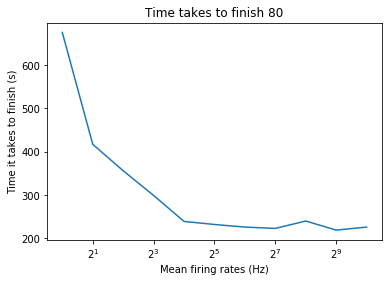

In [84]:
figure_behaviour, ax_behaviour = plt.subplots()

ax_behaviour.semilogx(neuron_firing_rates, finished_times_in_seconds)
ax_behaviour.set_xscale('log', basex=2)
ax_behaviour.set_title(f'Time takes to finish {N_TRIALS}')
ax_behaviour.set_xlabel('Mean firing rates (Hz)')
ax_behaviour.set_ylabel('Time it takes to finish (s)')

# Post data analysis

## Overall  trial statistics succuss rate)

In [18]:
state_logs = [e.state_log for e in exps]


In [19]:
STATE_CUT_NAME =  'wait'
#get the state logs
wait_logs = [filter_state(s, STATE_CUT_NAME) for s in state_logs]

inter_wait_times = [calc_inter_wait_times(w) for w in wait_logs]
#this has both start times 

Text(0, 0.5, 'Trial time (s)')

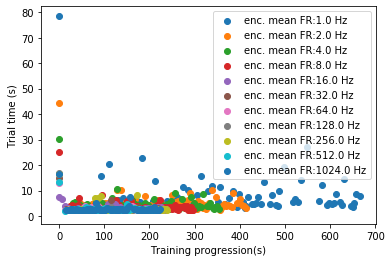

In [20]:
for i in inter_wait_times:
    plt.scatter(i[:,0], i[:,1])

plt.legend(exp_conds)
plt.xlabel('Training progression(s)')
plt.ylabel('Trial time (s)')

In [21]:
wait_time = inter_wait_times[0]
task_data_hist_np = task_data_hist_np_all[0]



In [22]:
def sort_trials(wait_time:list, 
                target_seq:list,
                task_data_hist_np:dict, 
                dict_keys, FRAME_RATE = 60):
    trial_dict = list()
    
    for i,row in enumerate(wait_time):
        start_time = row[0]
        inter_wait_time = row[1]

        start_sample = int(start_time * FRAME_RATE)
        inter_wait_sample = int(inter_wait_time * FRAME_RATE)
        stop_sample = start_sample + inter_wait_sample

        single_trial_dict = dict()

        for k in dict_keys:
            
            requested_type_data = np.squeeze(task_data_hist_np[k])
            single_trial_dict[k] =  requested_type_data[start_sample:stop_sample,
                                                       :]
        #add more info
        single_trial_dict['start_time'] = row[0]
        single_trial_dict['inter_wait_time'] = row[1]
        
        #add target info
        single_trial_dict['targets'] = target_seq[i]

        #add the dictionary to the list
        trial_dict.append(single_trial_dict)
        
    return trial_dict



In [23]:


trial_dicts_all = []
dict_keys = ['cursor', #behaviour
             'ctrl_input', 'spike_counts', #encoder translates intended ctrl into spike counts
             'decoder_state']

for i in range(NUM_EXP):
    wait_time = inter_wait_times[i]
    task_data_hist_np = task_data_hist_np_all[i]
    
    trial_dict_0 = sort_trials(wait_time, 
                               target_seq,
                               task_data_hist_np, dict_keys)
    
    trial_dicts_all.append(trial_dict_0)

len(trial_dicts_all)

11

## Trajectory analysis

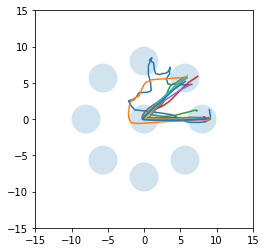

In [24]:
n_roi_trials = N_TRIALS - 1
unique_targets =  np.unique(target_seq, axis = 0)


X_CURSOR = 0
Z_CURSOR = 2
CIRCL_ALPHA = 0.2



RANGE_LIM =  15
figure, axes = plt.subplots() 

axes.set_xlim(-RANGE_LIM, RANGE_LIM)
axes.set_ylim(-RANGE_LIM, RANGE_LIM)

CIRCLE_RADIUS = exps[0].target_radius

#plot the targets

#plot the origin

cc = plt.Circle((0,0 ), 
            radius = CIRCLE_RADIUS,
            alpha = CIRCL_ALPHA)

axes.add_artist( cc ) 

for origin_t in unique_targets:
    origin = origin_t[0]
    t = origin_t[1]

    cc = plt.Circle((t[X_CURSOR],t[Z_CURSOR] ), 
                    radius = CIRCLE_RADIUS,
                    alpha = CIRCL_ALPHA)
                     
    axes.set_aspect( 1 ) 
    axes.add_artist( cc ) 
    
    
for trial_dict in trial_dicts_all:
    
    sample_trial = trial_dict[n_roi_trials]
    trial_cursor_trajectory = sample_trial['cursor']
    
    
    axes.plot(trial_cursor_trajectory[:, X_CURSOR], 
             trial_cursor_trajectory[:, Z_CURSOR])
    N_TRIALS = 80



In [25]:
print('finished trials:')

for i,e in  enumerate(exps): 
    reward_num = e.calc_state_occurrences('reward')
    print(f'{exp_conds[i]}: {reward_num} out of {N_TRIALS}')

finished trials:
enc. mean FR:1.0 Hz: 80 out of 80
enc. mean FR:2.0 Hz: 80 out of 80
enc. mean FR:4.0 Hz: 80 out of 80
enc. mean FR:8.0 Hz: 80 out of 80
enc. mean FR:16.0 Hz: 80 out of 80
enc. mean FR:32.0 Hz: 80 out of 80
enc. mean FR:64.0 Hz: 80 out of 80
enc. mean FR:128.0 Hz: 80 out of 80
enc. mean FR:256.0 Hz: 80 out of 80
enc. mean FR:512.0 Hz: 80 out of 80
enc. mean FR:1024.0 Hz: 80 out of 80


## encoder

the job of the encoder is to directly encode intention into firing rates
the direct measure is just pearson correlation coefficients between 
the intentions and the firing rates

In [26]:
print('the encoder observation Q matrix')
for i,e in enumerate(exps):
    print(exp_conds[i])
    print(e.encoder.ssm.w)

the encoder observation Q matrix
enc. mean FR:1.0 Hz
7
enc. mean FR:2.0 Hz
7
enc. mean FR:4.0 Hz
7
enc. mean FR:8.0 Hz
7
enc. mean FR:16.0 Hz
7
enc. mean FR:32.0 Hz
7
enc. mean FR:64.0 Hz
7
enc. mean FR:128.0 Hz
7
enc. mean FR:256.0 Hz
7
enc. mean FR:512.0 Hz
7
enc. mean FR:1024.0 Hz
7


In [27]:
n_exp = 0


spike_count_sample = trial_dicts_all[n_exp][n_roi_trials]['spike_counts']

## decoder

steady state tuning curves:


Text(0, -0.27999999999999997, 'CLDA rho 0.5')

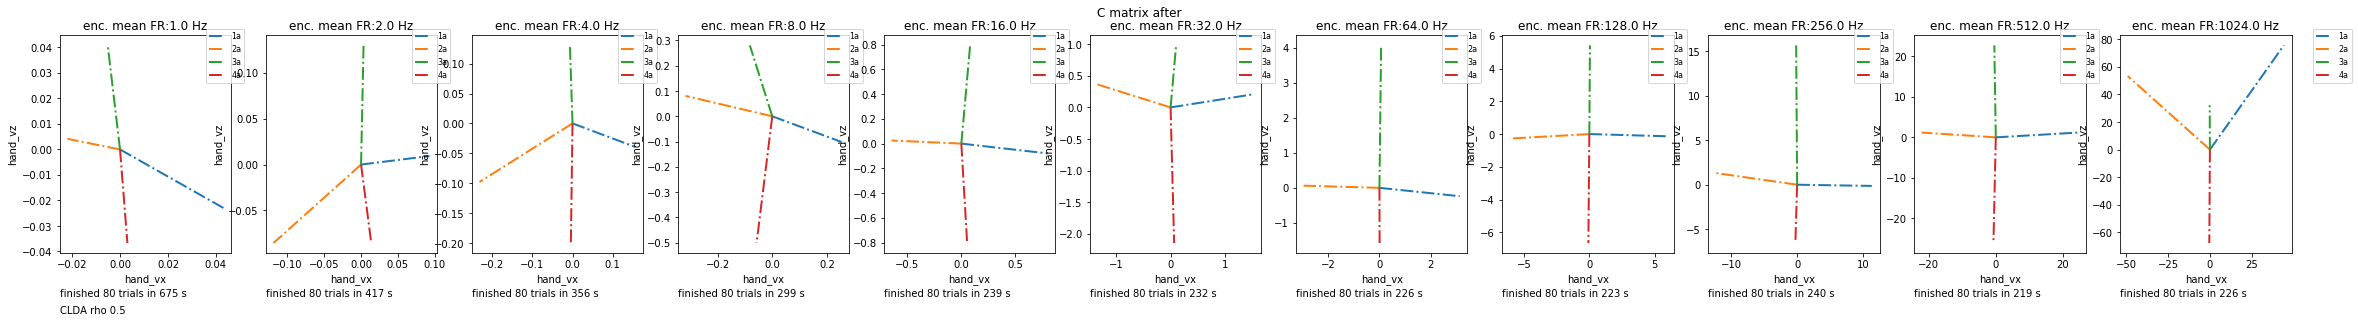

In [91]:
TEXT_OFFSET_VERTICAL = -0.2

figure_decoder_c_after,axs = plt.subplots(1, NUM_EXP,
                                  figsize = (40,4))

figure_decoder_c_after.suptitle('C matrix after')

print('steady state tuning curves:')
for i,e in enumerate(exps):
    e.decoder.plot_C(ax = axs[i])
    axs[i].set_title(exp_conds[i])
    
    #get the lower left coordinate
    y_lim_range  = axs[i].get_ylim()[1] - axs[i].get_ylim()[0]
    
    axs[i].text(0, TEXT_OFFSET_VERTICAL,
                f'finished {N_TRIALS} trials in {finished_times_in_seconds[i]} s', 
               transform = axs[i].transAxes)

figure_decoder_c_after.text(0, 1.4 * TEXT_OFFSET_VERTICAL, 
                     f'CLDA rho {RHO}',
                    transform = axs[0].transAxes)


the convergence time
change in the decoder parameter.
when the decoder parameter 

make a plot 
convergence time on the y axis.
more continuous SNR range. 
parametrically,  

error metric
what the deocder converges.
1. compared to the encoder.

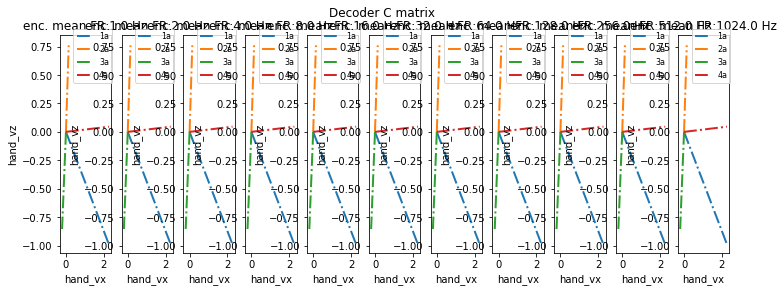

In [29]:
decoder_c_figure

## compare before and after the training

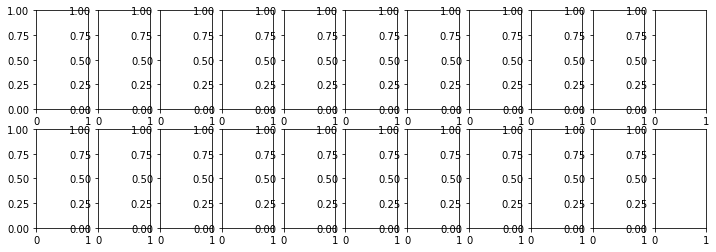

In [30]:


N_ROWS = 2 #before and after 
FIGURE_SIZE_2_by_4 = (12,4)
figure_compare_decoder_C_matrix,axs = plt.subplots(2,NUM_EXP, 
                                                   figsize = (12,4))

for i in range(NUM_EXP):
    axs[0, i] = decoder_c_figure.get_axes()[i]
    axs[1, i] = decoder_c_after.get_axes()[i]
    

# CLDA updates

## clda update frequencies

In [31]:

clda_params_all = [np.array(e.bmi_system.param_hist) for e in exps]

for c in clda_params_all:
    print(f'did clda for {len(c)} times')

did clda for 135 times
did clda for 83 times
did clda for 71 times
did clda for 59 times
did clda for 47 times
did clda for 46 times
did clda for 45 times
did clda for 44 times
did clda for 48 times
did clda for 43 times
did clda for 45 times


In [32]:
update_bmi_all = np.squeeze(task_data_hist_np_all[0]['update_bmi'])

Text(0.5, 0, 'frame count')

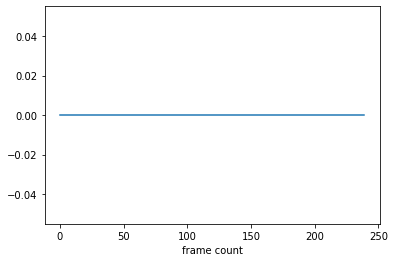

In [33]:
plt.plot(update_bmi_all[:240])
plt.xlabel('frame count')

## reformat the matrix

In [34]:
clda_params = clda_params_all[1]

clda_params_dict_all = list()

for p in clda_params_all:
    clda_params_dict = dict()
    for param_key in p[0].keys():
        clda_params_dict[param_key] = np.array([ record_i[param_key] for record_i in p])
    
    clda_params_dict_all.append(clda_params_dict)


len(clda_params_dict_all)

11

## observation covariance matrix

In [35]:
n_sample = 1

for i,c in enumerate(clda_params_dict_all):
    print(exp_conds[i])
    print(c['kf.Q'][n_sample,:,:])
    print()

enc. mean FR:1.0 Hz
[[2.92 0.   0.   0.  ]
 [0.   2.5  0.   0.  ]
 [0.   0.   2.79 0.  ]
 [0.   0.   0.   2.5 ]]

enc. mean FR:2.0 Hz
[[3.34 0.   0.07 0.  ]
 [0.   2.5  0.   0.  ]
 [0.07 0.   3.09 0.  ]
 [0.   0.   0.   2.5 ]]

enc. mean FR:4.0 Hz
[[ 4.26  0.    0.19 -0.01]
 [ 0.    2.5   0.    0.  ]
 [ 0.19  0.    4.54 -0.  ]
 [-0.01  0.   -0.    2.51]]

enc. mean FR:8.0 Hz
[[ 4.84  0.   -0.49  0.03]
 [ 0.    2.5   0.    0.  ]
 [-0.49  0.    7.82  0.01]
 [ 0.03  0.    0.01  2.54]]

enc. mean FR:16.0 Hz
[[ 8.36  1.35  2.94  2.82]
 [ 1.35  6.32  2.8   3.17]
 [ 2.94  2.8  13.78  6.63]
 [ 2.82  3.17  6.63 11.34]]

enc. mean FR:32.0 Hz
[[13.14  1.34  2.06  2.58]
 [ 1.34 10.81  2.62  1.97]
 [ 2.06  2.62 20.84 11.51]
 [ 2.58  1.97 11.51 25.2 ]]

enc. mean FR:64.0 Hz
[[ 49.89  18.07   3.06   9.67]
 [ 18.07  56.64   3.01  16.98]
 [  3.06   3.01 296.12 270.83]
 [  9.67  16.98 270.83 337.89]]

enc. mean FR:128.0 Hz
[[ 781.26  669.66  216.93  221.28]
 [ 669.66  675.28  192.62  188.7 ]
 [ 216.93  

## clda K matrix

In [36]:
kf_C = clda_params_dict['kf.C']

In [37]:
print('K matrix before:')
print(kf_C[0,:,:])
print('K matrix after:')
print(kf_C[-1,:,:])

K matrix before:
[[  0.     0.     0.    43.68   0.    -3.98 557.46]
 [  0.     0.     0.    -8.4    0.    -3.26 573.71]
 [  0.     0.     0.     0.58   0.    47.81  82.17]
 [  0.     0.     0.     1.76   0.    -3.04  86.61]]
K matrix after:
[[  0.     0.     0.    44.07   0.    75.49 316.1 ]
 [  0.     0.     0.   -49.03   0.    53.24 309.67]
 [  0.     0.     0.    -0.13   0.    32.14  82.78]
 [  0.     0.     0.    -0.36   0.   -67.64  82.65]]


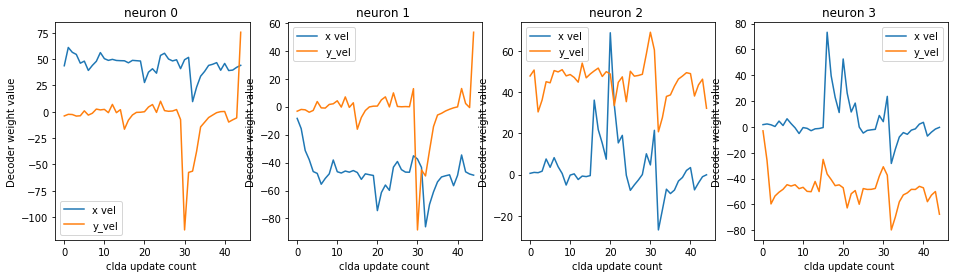

In [38]:
N_CLDA_ROI_TIME = 800

FIGURE_SIZE = (2,10)

N_NEURONS

f, axs = plt.subplots(1,N_NEURONS,figsize=(16,4))

for i in range(N_NEURONS):
    axs[i].plot(np.squeeze(kf_C[:N_CLDA_ROI_TIME,i, X_VEL_STATE_IND]))
    axs[i].plot(np.squeeze(kf_C[:N_CLDA_ROI_TIME,i, Y_VEL_STATE_IND]))
    axs[i].legend(['x vel', 'y_vel'])
    axs[i].set_title(f'neuron {i} ')
    axs[i].set_xlabel('clda update count ')
    axs[i].set_ylabel('Decoder weight value')



In [39]:
exps[0].encoder.C

array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  0.]])

## examine training batches

In [40]:
spike_counts_batch = clda_params_dict['spike_counts_batch'] 
intended_kin = clda_params_dict['intended_kin']

In [41]:
training_sample_point = 2

print('intended kinematics:')
print(intended_kin[training_sample_point])

print('spike counts:')
print(spike_counts_batch[training_sample_point])

print('trained KF C matrix:')
#print(kf_C[training_sample_point])

intended kinematics:
[[  4.29   5.42   6.5    7.44   8.19   8.73   9.03   9.11   9.06   8.92
    8.71   8.49   8.29   8.11   7.94   6.97   5.61   4.     2.37   0.88
   -0.35  -1.2   -1.68  -1.81  -0.85   0.71   2.63   4.59   6.46   8.06
    9.27  10.04  10.4   10.41  10.17   9.7    9.17   8.68   8.27   7.94
    7.71   7.56   7.48   7.43   6.52   5.19   3.66   2.15   0.81  -0.28]
 [  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.  ]
 [ 11.68   8.68   5.58   2.58   0.16  -1.76  -2.98  -3.57  -3.65  -3.32
   -2.72  -2.    -1.25  -0.53   0.01   0.39   0.59   0.67   0.62   0.47
    0.28   0.07  -0.09  -0.23  -0.32  -0.34  -0.31  -0.26  -0.17  -0.08
    0.02   0.08   0.12   0.12   0.1    0.05  -0.0

# feature analyses

In [42]:
import statsmodels.api as sm


## Examine relevance of one neuron from one batch 

### Select data

In [43]:
clda_params_dict.keys() # this is from one experiment

dict_keys(['kf.C', 'kf.Q', 'kf.C_xpose_Q_inv_C', 'kf.C_xpose_Q_inv', 'mFR', 'sdFR', 'rho', 'intended_kin', 'spike_counts_batch'])

In [44]:
spike_counts_batch = clda_params_dict['spike_counts_batch']
intended_kin = clda_params_dict['intended_kin']
print(f'{len(spike_counts_batch)}')
print(f'{len(intended_kin)}')

45
45


In [45]:
# we just take one batch
batch_of_interest = 0
spike_count_one_batch = spike_counts_batch[batch_of_interest]
intended_kin_one_batch = intended_kin[batch_of_interest]

print(f'look at one batch: batch number {batch_of_interest}')
print(f'spike count')
print(spike_count_one_batch)

print(f'intended kin')
print(intended_kin_one_batch)

look at one batch: batch number 0
spike count
[[    0.     0.   193.  1694.     0.     0. 67718.     0.     0.  3367.
   1871.  1864.  1983.  1985.  1838.  1804.  1891.  1931.  1997.  1972.
   1906.  1900.  1889.  1854.  1954.  1950.  2033.  1877.  1882.  1874.
   1942.  1945.  1969.  1964.  1934.  1937.  1964.  1934.  1948.  1896.
   1894.  1964.  1947.  1994.  2032.  2015.  1916.  1886.  1899.  1876.]
 [    0.     8.     0.     0.   518. 28092.     0.   517.  2914.     0.
      0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
      0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
      0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
      0.     0.     0.     0.     0.     0.     0.     0.     0.     0.]
 [    0.     0.   184.     0.  9882.  1182.     0.  1238.  1183. 19499.
   1331.  1203.  1239.  1249.  1203.  1192.  1179.  1210.  1245.  1233.
   1278.  1227.  1201.  1184.  1268.  1191.  1237.  1244.  1186.  1224.
   1195.  1296. 

In [46]:
print('we are dealing with a velocity decoder')
print('we only look at  x vel and y vel:')
print('We assume we are only interested how firing rates encode x, y vel')

intended_kin_one_batch_2D = intended_kin_one_batch[(X_VEL_STATE_IND, Y_VEL_STATE_IND),:]
print('after selecting the vels:')
print(intended_kin_one_batch_2D)

we are dealing with a velocity decoder
we only look at  x vel and y vel:
We assume we are only interested how firing rates encode x, y vel
after selecting the vels:
[[   0.     -0.13    8.99   16.39   -5.16 -271.42  665.49   -5.16  -28.47
    33.21   18.92   18.92   18.92   18.92   18.92   18.92   18.92   18.92
    18.92   18.92   18.92   18.92   18.92   18.92   18.92   18.92   18.92
    18.92   18.92   18.92   18.92   18.92   18.92   18.92   18.92   18.92
    18.92   18.92   18.92   18.92   18.92   18.92   18.92   18.92   18.92
    18.92   18.92   18.92   18.92   18.92]
 [   0.     -0.24    1.84  -41.52   96.2    12.04  -12.04   12.04   12.04
   190.41   12.04   12.04   12.04   12.04   12.04   12.04   12.04   12.04
    12.04   12.04   12.04   12.04   12.04   12.04   12.04   12.04   12.04
    12.04   12.04   12.04   12.04   12.04   12.04   12.04   12.04   12.04
    12.04   12.04   12.04   12.04   12.04   12.04   12.04   12.04   12.04
    12.04   12.04   12.04   12.04   12.04]]


In [47]:
print('we will do  one neuron at a time')
n_roi_neuron = 0
print(f'the neuron that we are interested is neuron {n_roi_neuron}')
print('and selected firing rates:')

spike_count_one_batch_one_neuron = spike_count_one_batch[n_roi_neuron,:]

print(spike_count_one_batch_one_neuron)

we will do  one neuron at a time
the neuron that we are interested is neuron 0
and selected firing rates:
[    0.     0.   193.  1694.     0.     0. 67718.     0.     0.  3367.
  1871.  1864.  1983.  1985.  1838.  1804.  1891.  1931.  1997.  1972.
  1906.  1900.  1889.  1854.  1954.  1950.  2033.  1877.  1882.  1874.
  1942.  1945.  1969.  1964.  1934.  1937.  1964.  1934.  1948.  1896.
  1894.  1964.  1947.  1994.  2032.  2015.  1916.  1886.  1899.  1876.]


### OLS model fitting

In [48]:
print('we transpose the vector for fitting')
X = intended_kin_one_batch_2D.T
y = np.reshape(spike_count_one_batch_one_neuron, (-1,1))


print('the independent variables are  the intended kin hence, X')
print(X)


print('the dependent variable is the neuron spike connt, hence y')
print(y)


we transpose the vector for fitting
the independent variables are  the intended kin hence, X
[[   0.      0.  ]
 [  -0.13   -0.24]
 [   8.99    1.84]
 [  16.39  -41.52]
 [  -5.16   96.2 ]
 [-271.42   12.04]
 [ 665.49  -12.04]
 [  -5.16   12.04]
 [ -28.47   12.04]
 [  33.21  190.41]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12

In [49]:
print('we add the constant one to the states (X)')
X = sm.add_constant(X, has_constant= 'raise')
print('the new X is')
print(X)

we add the constant one to the states (X)
the new X is
[[   1.      0.      0.  ]
 [   1.     -0.13   -0.24]
 [   1.      8.99    1.84]
 [   1.     16.39  -41.52]
 [   1.     -5.16   96.2 ]
 [   1.   -271.42   12.04]
 [   1.    665.49  -12.04]
 [   1.     -5.16   12.04]
 [   1.    -28.47   12.04]
 [   1.     33.21  190.41]
 [   1.     18.92   12.04]
 [   1.     18.92   12.04]
 [   1.     18.92   12.04]
 [   1.     18.92   12.04]
 [   1.     18.92   12.04]
 [   1.     18.92   12.04]
 [   1.     18.92   12.04]
 [   1.     18.92   12.04]
 [   1.     18.92   12.04]
 [   1.     18.92   12.04]
 [   1.     18.92   12.04]
 [   1.     18.92   12.04]
 [   1.     18.92   12.04]
 [   1.     18.92   12.04]
 [   1.     18.92   12.04]
 [   1.     18.92   12.04]
 [   1.     18.92   12.04]
 [   1.     18.92   12.04]
 [   1.     18.92   12.04]
 [   1.     18.92   12.04]
 [   1.     18.92   12.04]
 [   1.     18.92   12.04]
 [   1.     18.92   12.04]
 [   1.     18.92   12.04]
 [   1.     18.92   12.04]


In [50]:
print('now we can fit using statsmodels.ols')

ols_spike_from_states = sm.OLS(y, X)

results_ols_spike_from_states = ols_spike_from_states.fit()

print('print results')
print(results_ols_spike_from_states.summary())

now we can fit using statsmodels.ols
print results
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     140.9
Date:                Thu, 11 Mar 2021   Prob (F-statistic):           1.41e-20
Time:                        14:02:43   Log-Likelihood:                -479.05
No. Observations:                  50   AIC:                             964.1
Df Residuals:                      47   BIC:                             969.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c

In [51]:
print('the p-values test against if the coefficients are zero')
neuron_batch_pvalue = results_ols_spike_from_states.pvalues

print(f'the p values for this neuron of index {n_roi_neuron}')
print(neuron_batch_pvalue)

neuron_batch_coeff = results_ols_spike_from_states.params

print('the reg. coeff. are ')
print(neuron_batch_coeff)

print()
significance_level = 0.05
print(f'at a significance_level of {significance_level}:')
print('this array has the indix of the states that are significantly correlated with the firing rates  ')

np.where(neuron_batch_pvalue < significance_level)

the p-values test against if the coefficients are zero
the p values for this neuron of index 0
[0.07 0.   0.69]
the reg. coeff. are 
[1113.97   85.11   -6.98]

at a significance_level of 0.05:
this array has the indix of the states that are significantly correlated with the firing rates  


(array([1]),)

## iterate up the model testing procedure

In [52]:
print('we write a function that actually  check if any given neuron has a sig state')



        






we write a function that actually  check if any given neuron has a sig state


In [53]:
print('with the functions, we can fit and test the one neuron and against the state')

with the functions, we can fit and test the one neuron and against the state


In [54]:
significance_level = 0.05


    




In [55]:
from weights import fit_ols

print('we transpose the vector for fitting')
X = intended_kin_one_batch_2D.T
y = np.reshape(spike_count_one_batch_one_neuron, (-1,1))


print('the independent variables are  the intended kin hence, X')
print(X)


print('the dependent variable is the neuron spike connt, hence y')
print(y)

results = fit_ols(y, X)

print('fitting_results:')
print(results)


we transpose the vector for fitting
the independent variables are  the intended kin hence, X
[[   0.      0.  ]
 [  -0.13   -0.24]
 [   8.99    1.84]
 [  16.39  -41.52]
 [  -5.16   96.2 ]
 [-271.42   12.04]
 [ 665.49  -12.04]
 [  -5.16   12.04]
 [ -28.47   12.04]
 [  33.21  190.41]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12.04]
 [  18.92   12

## test across the neurons in a batch

In [56]:
spike_count_one_batch.shape

(4, 50)

In [57]:


n_roi_neuron = 0

#assume spike_count_one_batch has the shape N_NEURONS by N_time points
#assume that intended_kin_one_batch_2D has N_states by N_Time_points

'''

'''
#get intended kinematics this is fixed for each neuron
intended_kin_one_batch_2D = intended_kin_one_batch[(X_VEL_STATE_IND, Y_VEL_STATE_IND),:]
#('we transpose the vector for fitting')
intended_kin_one_batch_2D = intended_kin_one_batch_2D.T
spike_count_one_batch = intended_kin_one_batch.T

neuron_batch_pvalue_matrix = calc_single_batch_p_values_by_fitting_kinematics_to_spike_counts(spike_count_one_batch,
                                                                       intended_kin_one_batch_2D)

print(f'the pvalue matrix for a batch')
neuron_batch_pvalue_matrix

the pvalue matrix for a batch


/home/sijia-aw/BMi3D_my/lib/python3.8/site-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/home/sijia-aw/BMi3D_my/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/sijia-aw/BMi3D_my/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/sijia-aw/BMi3D_my/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/home/sijia-aw/BMi3D_my/operation_funny_chicken/adaptive_feature_selection/weights.py:218: RuntimeWarning: invalid value encountered in less_equal
  sig_test_list = np.where(p_value_array <= significance_level)


array([[0.86, 0.35, 0.  , 0.2 , 0.  ,  nan, 0.55, 0.8 ],
       [0.23, 0.24, 0.  , 0.98, 0.36,  nan, 0.  , 0.17]])

In [58]:


print('test out the calculate_p_value_matrix')

calc_p_value_matrix_result = calc_single_batch_p_values_by_fitting_kinematics_to_spike_counts(
                            intended_kin_one_batch_2D, 
                            spike_count_one_batch)
print(calc_p_value_matrix_result)
print()
print('for comparision, this is what we just calculated')
neuron_batch_pvalue_matrix

test out the calculate_p_value_matrix
[[0.   0.   0.  ]
 [ nan  nan  nan]
 [0.   0.   0.  ]
 [0.8  0.   0.08]
 [ nan  nan  nan]
 [0.53 0.   0.  ]
 [0.   0.09 0.16]]

for comparision, this is what we just calculated


array([[0.86, 0.35, 0.  , 0.2 , 0.  ,  nan, 0.55, 0.8 ],
       [0.23, 0.24, 0.  , 0.98, 0.36,  nan, 0.  , 0.17]])

## calculate p_values for a different batch

In [59]:
# we just take one batch
batch_of_interest = 1

intended_kin_one_batch = intended_kin[batch_of_interest]
intended_kin_one_batch_2D = intended_kin_one_batch[(X_VEL_STATE_IND, Y_VEL_STATE_IND),:]
spike_count_one_batch = spike_counts_batch[batch_of_interest]

print(intended_kin_one_batch_2D.shape)
spike_count_one_batch.shape

(2, 50)


(4, 50)

In [60]:
# we just take one batch
batch_of_interest = 1

intended_kin_one_batch = intended_kin[batch_of_interest]
intended_kin_one_batch_2D = intended_kin_one_batch[(X_VEL_STATE_IND, Y_VEL_STATE_IND),:].T
spike_count_one_batch = spike_counts_batch[batch_of_interest].T




calc_p_value_matrix_result = calc_single_batch_p_values_by_fitting_kinematics_to_spike_counts(
                            intended_kin_one_batch_2D, 
                            spike_count_one_batch)

print(calc_p_value_matrix_result)
print('here, the issues are if any of the rows are linearly dependent')
print('the fit just does not work')

[[0.   0.   0.65]
 [0.   0.   0.7 ]
 [0.   0.76 0.  ]
 [0.   0.55 0.  ]]
here, the issues are if any of the rows are linearly dependent
the fit just does not work


## calculate p_values across the batches

In [61]:
print(spike_counts_batch.shape)
print(intended_kin.shape)

(45, 4, 50)
(45, 7, 50)


In [62]:


batch_pvalue_matrix = calc_p_values_for_spike_batches_use_intended_kin(spike_counts_batch, 
                                                                       intended_kin)
    
print('we can check the type of the design matrix')
batch_pvalue_matrix.shape

regress on the states index : 3 and 5
we can check the type of the design matrix


(45, 4, 3)

we look at the batched p_value 0


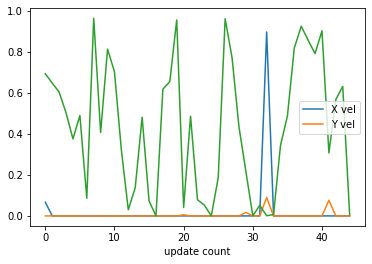

In [63]:
n_roi_neuron = 0
print(f'we look at the batched p_value {n_roi_neuron}')
batch_pvalue_matrix_neuron = np.squeeze(batch_pvalue_matrix[:,n_roi_neuron,:])

plt.plot(batch_pvalue_matrix_neuron)
plt.xlabel('update count')
plt.legend(['X vel', 'Y vel'])

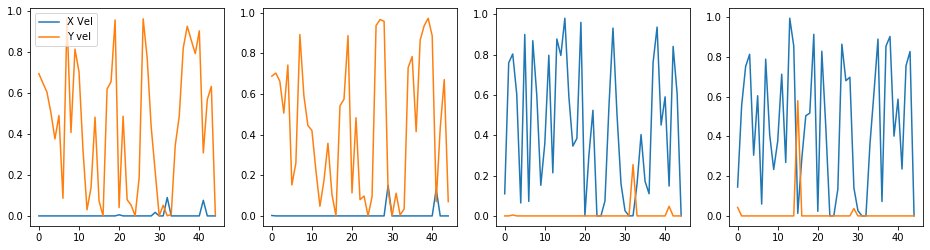

In [64]:



fig, axs = plt.subplots(1,N_NEURONS, figsize = (16,4))

for n in range(N_NEURONS):
    
    
    
    batch_pvalue_matrix_neuron = np.squeeze(batch_pvalue_matrix[:,n,:])
    axs[n].plot(batch_pvalue_matrix_neuron[:,1:])
    
    
    if n == 0: axs[n].legend(['X Vel', 'Y vel'])




the batch time is small
a batch should include at least 4 reaches.
very linear. all of a sudden, it gets way.

inside target, setting the int to zero. 
the hold vel is zero.  

## compare across conditions

In [65]:
for n in range(N_NEURONS):
    
    
    
    batch_pvalue_matrix_neuron = np.squeeze(batch_pvalue_matrix[:,n,:])
    axs[n].plot(batch_pvalue_matrix_neuron[:,1:])
    
    
    if n == 0: axs[n].legend(['X Vel', 'Y vel'])


# Summary of this analysis

## behaviour

we can look at trial time
Please check, because we fix the covariance value\
the SNR is simply the mean firing rates
as expected that, as we increase the mean firing rates, we decrease the training time


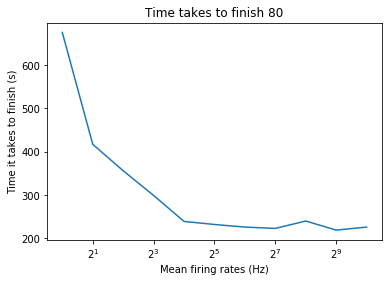

In [89]:
print('we can look at trial time')
print('Please check, because we fix the covariance value\\')
print('the SNR is simply the mean firing rates')
print('as expected that, as we increase the mean firing rates, we decrease the training time')

figure_behaviour

## decoder analysis

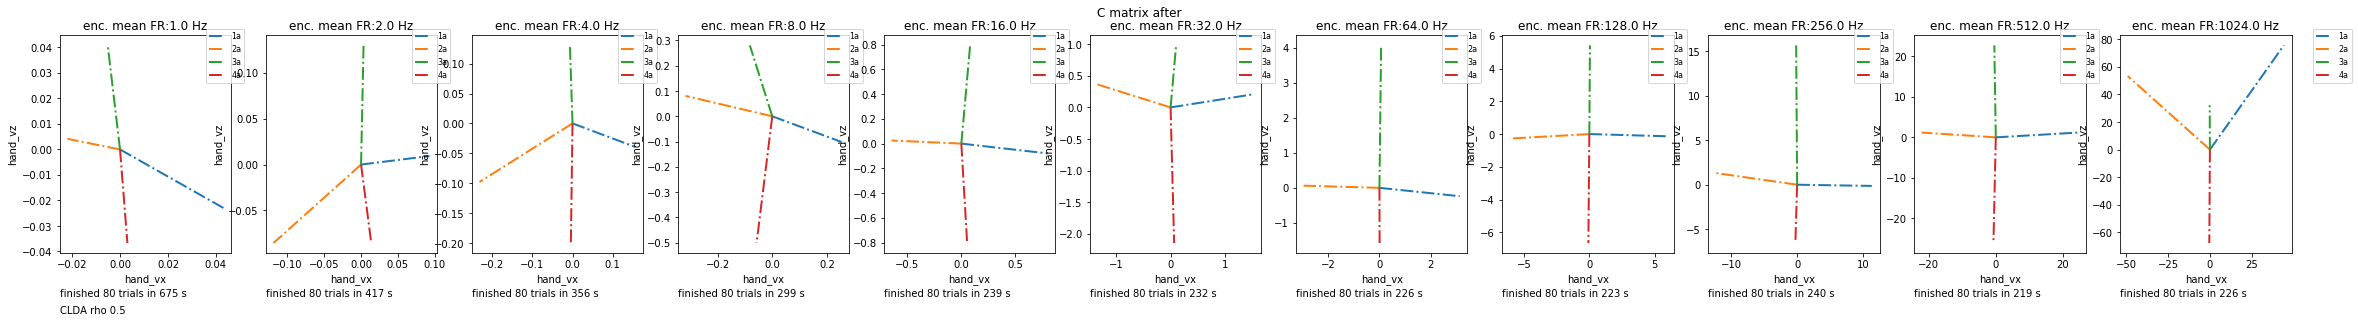

In [92]:
figure_decoder_c_after